In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys

sys.path.append("derrom/")

import derrom


In [2]:
trajectories = derrom.utils.load_trajectories(filename='../trajectories_n_kmax=200.npz')

# trajectories = trajectories[:100:1]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

1000 loaded with n_kmax = 200


In [3]:
rdim = 20

dim_reducer = derrom.dim_reducers.SVD()
# dim_reducer = derrom.dim_reducers.FFT(sorted=True)
# dim_reducer = derrom.dim_reducers.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=True, train_rdim=rdim)

model = derrom.utils.reducer_helper_class(trajectories, dim_reducer)
model.train()
# print(dim_reducer.sample_max)

# print(model.get_error(trajectories[9], rdim=rdim, norm='rms'))

In [5]:
rdim = 20

dim_reducer = derrom.dim_reducers.SVD()
# dim_reducer = derrom.dim_reducers.FFT(sorted=True)
# dim_reducer = derrom.dim_reducers.Hermite(sample_max = 1.856, sorted=True, optimize=True, orthogonalize=True, train_rdim=rdim)

model = derrom.utils.reducer_helper_class(trajectories, dim_reducer)

train_kwargs = {'rdim':rdim}

scores = derrom.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817, norms=['rms','max'], train_kwargs=train_kwargs)

print('rms error: ', str(np.mean(scores[0])) + '+-' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + '+-' + str(np.std(scores[1])) )


rms error:  0.0008562335945817372+-0.0006668852922460577
max error:  0.02193179394029813+-0.023852490068022446


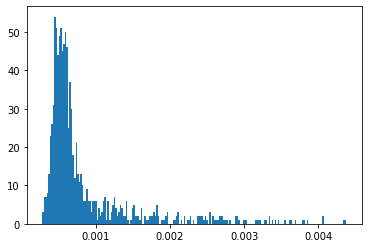

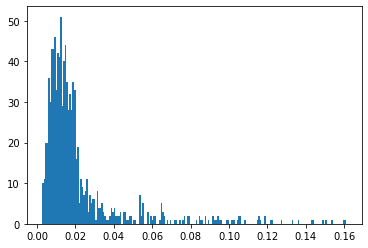

In [12]:
plt.hist(scores[0],bins=200)
plt.show()

plt.hist(scores[1],bins=200)
plt.show()

In [ ]:
norm = 'rms'
threshold = 0.01

# n_kmax_ar = [220,230]
n_kmax_ar = [10,20,30,40]
# n_kmax_ar = np.arange(10,235,10)
n_kmax_ar = np.arange(50,255,10)

rdim_buffer = 5
previous_min_rdim = 1 + rdim_buffer
min_rdim_ar = []

for k, n_kmax in enumerate(n_kmax_ar):
    trajectories = derrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/runs/runs_n_kmax='+str(n_kmax)+'.npz')
    n_trajectories = len(trajectories)
    for k in range(len(trajectories)):
        trajectories[k] = trajectories[k].T
    assert n_kmax == trajectories[0].shape[1]
    
    print(n_trajectories, 'loaded with n_kmax =', n_kmax)
    
    for rdim in range(previous_min_rdim-rdim_buffer,n_kmax+1):
        
        try:
            dim_reducer = derrom.dim_reducer.SVD()
#             dim_reducer = derrom.dim_reducer.FFT(sorted=True)
#             dim_reducer = derrom.dim_reducer.Hermite(sorted=True, optimize=True, orthogonalize=True, train_rdim=rdim)

            model = derrom.utils.reducer_helper_class(dim_reducer=dim_reducer)

            train_kwargs = {'rdim':rdim}

            scores = derrom.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817, norms=[norm], train_kwargs=train_kwargs)
            
            mean = np.mean(scores[0])
            std = np.std(scores[0])

            score = mean+std

            if score < threshold:
                previous_min_rdim = rdim
                min_rdim_ar.append(rdim)
                print('min rdim:', rdim, 'mean + std', score)
                break
        except:
            score = 10.0
            
    if score > threshold:        
        min_rdim_ar.append(rdim)
        print('max rdim reached:', rdim, 'mean score', score)
    

In [ ]:
n_kmax_ar = np.asarray(n_kmax_ar)
min_rdim_ar = np.asarray(min_rdim_ar)

data = np.stack((n_kmax_ar[:min_rdim_ar.size],min_rdim_ar),axis=1)

# prev_data = np.loadtxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/hermite_max')
# data = np.concatenate((prev_data,data),axis=0)


print(data.shape)
print(data)

# np.savetxt('/home/agluedge/Preprints/ELPH/figs/red_dim_apprx/hermite_max_2', data)



plt.grid()
plt.plot(data[:,0],data[:,1], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim')
plt.show()


plt.grid()
plt.plot(data[:,0],data[:,1]/data[:,0], '--', marker='o')
plt.xlabel('n_kmax')
plt.ylabel('min rdim/n_kmax')
plt.show()